<a href="https://colab.research.google.com/github/kashishthakur26/Natural_language_processing/blob/main/BERT_for_Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense , SpatialDropout1D , Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
##import dataset from github
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [3]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
tweet.describe()

In [6]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Exploratory Data Analysis

#### Target class distribution

In [7]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

Text(0.5, 1.0, 'Real or Not Real disaster Tweet')

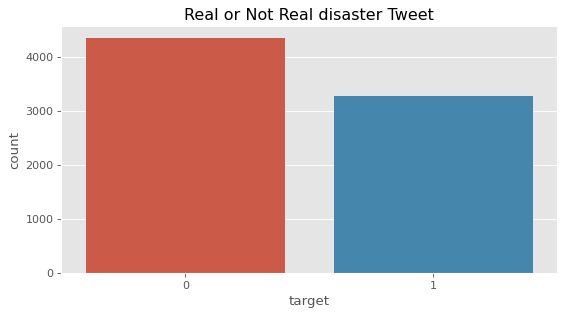

In [8]:
sns.countplot(data=tweet, x='target')
plt.title('Real or Not Real disaster Tweet')


In [9]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<Axes: ylabel='target'>

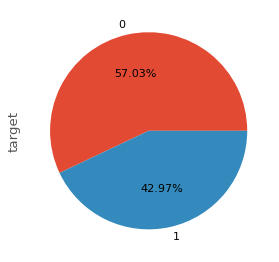

In [10]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [11]:
## importing preprocess_package_from github
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-j_cbr7m5
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-j_cbr7m5
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7621 sha256=1b26c08f6fe7be229245906f689a053c77d48d71a90d33461bd001bba040bfcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-uox6f6dg/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [12]:
import preprocess_kgptalkie as pp

In [13]:
tweet = pp.get_basic_features(tweet)

In [14]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


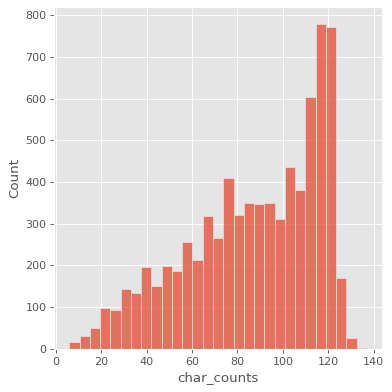

In [15]:
sns.displot(tweet['char_counts'])

<ipython-input-16-7433aa2a83b9>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet['char_counts'], shade=True)


<Axes: xlabel='char_counts', ylabel='Density'>

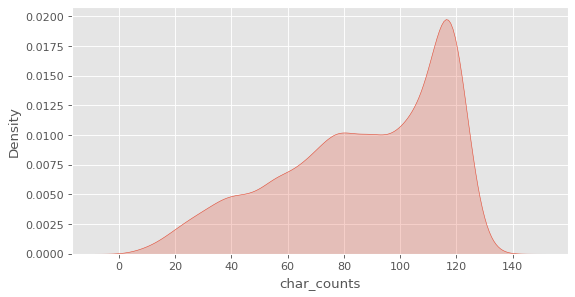

In [16]:
sns.kdeplot(tweet['char_counts'], shade=True)

<ipython-input-17-4c013d23f0f8>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
<ipython-input-17-4c013d23f0f8>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')


<Axes: xlabel='char_counts', ylabel='Density'>

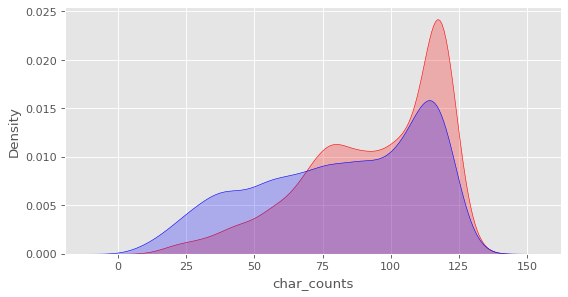

In [17]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

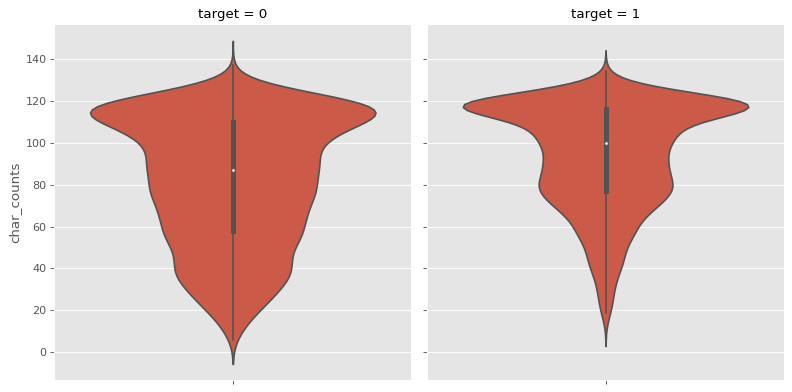

In [18]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

#### Number of words average words length and stop words distribution in tweets

<ipython-input-19-48b4fde55523>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
<ipython-input-19-48b4fde55523>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


<Axes: xlabel='word_counts', ylabel='Density'>

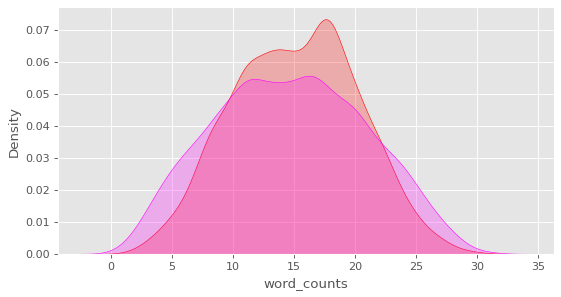

In [19]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


<ipython-input-20-0ecd8b72bcb9>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
<ipython-input-20-0ecd8b72bcb9>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


<Axes: xlabel='avg_wordlength', ylabel='Density'>

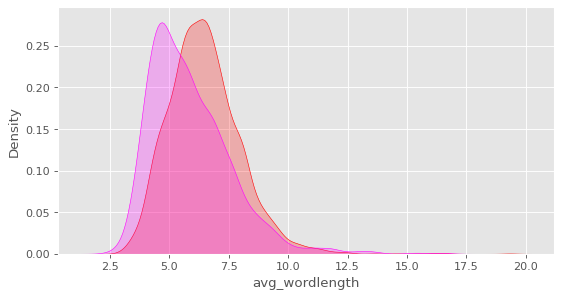

In [20]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


<ipython-input-21-696949065a33>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
<ipython-input-21-696949065a33>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


<Axes: xlabel='stopwords_counts', ylabel='Density'>

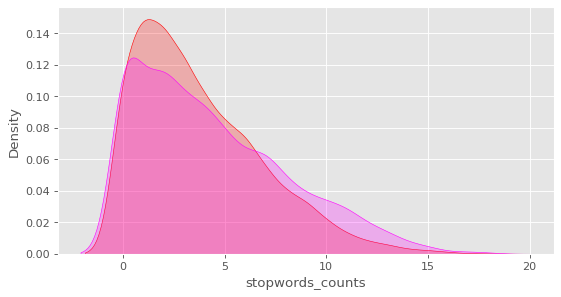

In [21]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [22]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

In [23]:
#most and least common words
freqs = pp.get_word_freqs(tweet,'text')
top20 = freqs[100:120]

In [24]:
freqs.head()

the    2575
a      1845
to     1805
in     1757
of     1722
dtype: int64

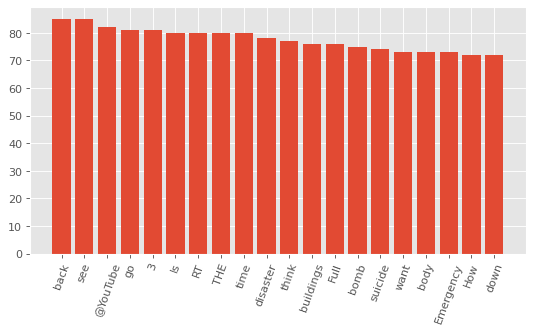

In [25]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [26]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [27]:
bigram = pp.get_ngram(tweet, 'text', ngram_range=2)

In [28]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

#### One shot data cleaning

In [29]:
def get_clean(x):
  x= str(x).lower().replace('\\',' ').replace('.',' ')
  x = pp.cont_exp(x)
  x = pp.remove_emails(x)
  x = pp.remove_urls(x)
  x = pp.remove_html_tags(x)
  x = pp.remove_rt(x)
  x = pp.remove_accented_chars(x)
  x = pp.remove_special_chars(x)
  x = pp.remove_dups_char(x)

  return x

In [30]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [31]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

#### disaster words visualization with word cloud

In [32]:
real = pp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire was are as have my news httpst over up more via an disaster were be people california suicide has no police who but when been killed like do will 2 hiroshima just than so out fires storm crash families we train about into now emergency s your buildings bomb all there mh370 what two they am nuclear attack wildfire video accident get one bombing minister burning northern new prime how legionnaires dead me bomber if some homes war car atomic still obama he fatal years off us forest collapse debris may watch city first malaysia japan man latest mass 1 or retweet near water severe today had earthquake those confirmed before would oil found 70 floods spill world army down home under warning 3 derailment wreckage outbreak weather injured evacuation 4 could being 40 saudi thunderstorm migrants old our can flooding during flood say missing investigators their time bridge back state death mosque her suspect kil

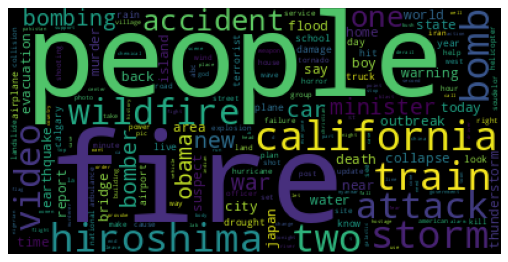

In [33]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

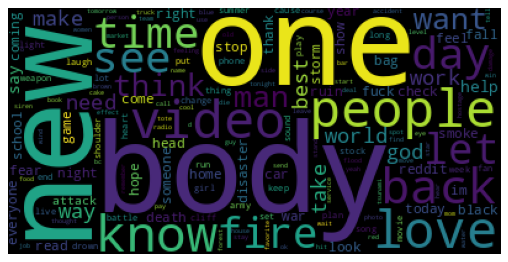

In [35]:
# not real plot

nreal = pp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Classification with TFID and SVM

In [36]:
text = tweet['text']
y = tweet['target']

In [37]:
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(text)

In [38]:
x.shape

(7613, 22539)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [40]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [41]:
from sklearn.svm import LinearSVC

In [42]:
clf = LinearSVC()
run_SVM(clf, x_train, x_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Classifcation with word2vec

In [43]:
!python -m spacy download en_core_web_lg

2023-08-17 17:59:00.980308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [48]:
import spacy

In [49]:
import en_core_web_lg

In [52]:
nlp = en_core_web_lg.load()

In [53]:
x = 'cat dog'
doc = nlp(x)

In [54]:
doc.vector.shape

(300,)

In [55]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [56]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [ ]:
tweet.head()

In [57]:
x = tweet['vec'].to_numpy()
x = x.reshape(-1,1)

In [58]:
x.shape

(7613, 1)

In [59]:
x = np.concatenate(np.concatenate(x,axis=0), axis=0).reshape(-1,300)

In [60]:
x.shape

(7613, 300)

In [61]:
y =tweet['target']

In [62]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2 , random_state=0 , stratify=y)

In [63]:
%%time
clf = LinearSVC()
run_SVM(clf, x_train , x_test ,y_train , y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.74      0.94      0.83       869
           1       0.87      0.56      0.68       654

    accuracy                           0.78      1523
   macro avg       0.80      0.75      0.75      1523
weighted avg       0.80      0.78      0.76      1523

CPU times: user 10.7 s, sys: 50.7 ms, total: 10.7 s
Wall time: 14.4 s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Word Embeddings and classification with Deep Learning

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Embedding , Dropout
from tensorflow.keras.layers import Conv1D , MaxPooling1D , GlobalMaxPooling1D

In [65]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria_ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [66]:
token = Tokenizer()
token.fit_on_texts(text)

In [67]:
vocab_size = len(token.word_index) + 1

In [68]:
vocab_size

22588

In [69]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [71]:
encoded_text = token.texts_to_sequences(text)

In [72]:
print(encoded_text)

[[109, 4494, 22, 2, 868, 6, 20, 246, 129, 1681, 4495, 74, 41], [186, 43, 223, 762, 6795, 6796, 1328], [41, 1682, 1435, 5, 2061, 4, 655, 22, 125, 6797, 19, 1683, 42, 437, 253, 58, 2061, 4, 655, 1329, 22, 1054], [2809, 56, 4496, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6798, 2062, 29, 261, 23, 1330, 6799, 68, 3, 189], [2810, 390, 86, 1553, 793, 829, 4, 637, 6800, 534, 5, 1106, 372, 43, 4497, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1861, 4, 6801, 999, 2343, 1554], [7, 31, 12, 225, 6, 2, 1862, 8, 7, 71, 103, 3, 43, 4, 2, 4498], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2344, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3468, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6802, 247], [2813, 247, 2063, 6803, 2811, 1436, 58, 1863, 614, 7, 21, 735, 3469], [224, 4, 4499, 912, 49, 1684, 4499], [241, 5, 189, 391, 12, 2345, 4, 4500, 126, 87, 355], [638, 34, 96], [7, 110

In [73]:
max_length = 40
x = pad_sequences(encoded_text, maxlen=max_length,padding='post')

In [75]:
print(x)

[[ 109 4494   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2294 4486 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [76]:
x.shape

(7613, 40)

In [77]:
x_train , x_test , y_train , y_test = train_test_split(x,y,test_size=0.2 , random_state=0, stratify=y)

In [78]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [80]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           2258800   
                                                                 
 conv1d (Conv1D)             (None, 39, 32)            6432      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 32)            0         
                                                                 
 dense (Dense)               (None, 19, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 19, 32)            0         
                                                        

In [82]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
191/191 [==============================] - 12s 50ms/step - loss: 0.6690 - accuracy: 0.5875 - val_loss: 0.6274 - val_accuracy: 0.6848
Epoch 2/5
191/191 [==============================] - 7s 34ms/step - loss: 0.5165 - accuracy: 0.7598 - val_loss: 0.5171 - val_accuracy: 0.7663
Epoch 3/5
191/191 [==============================] - 9s 47ms/step - loss: 0.3509 - accuracy: 0.8626 - val_loss: 0.5370 - val_accuracy: 0.7137
Epoch 4/5
191/191 [==============================] - 11s 59ms/step - loss: 0.2310 - accuracy: 0.9215 - val_loss: 0.5712 - val_accuracy: 0.7144
Epoch 5/5
191/191 [==============================] - 11s 56ms/step - loss: 0.1711 - accuracy: 0.9440 - val_loss: 0.6600 - val_accuracy: 0.6783
CPU times: user 50.2 s, sys: 4.1 s, total: 54.3 s
Wall time: 1min 24s


In [83]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [84]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [85]:
vec

array([[  7,  31,   5, 103,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [86]:
np.argmax(model.predict(vec), axis = -1)

1/1 [==============================] - 0s 262ms/step


array([0])

### BERT Model Building and Training

In [87]:
!pip install ktrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 22.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 27.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 36.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [88]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [89]:
from ktrain import text
import ktrain

In [90]:
(x_train ,y_train),(x_test,y_test), preproc = text.texts_from_df(train_df=tweet , text_column='text',label_columns='target',maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
5122         0.0     1.0
3960         0.0     1.0
1457         0.0     1.0
6173         1.0     0.0
1355         1.0     0.0
['not_target', 'target']
      not_target  target
3192         0.0     1.0
5912         1.0     0.0
4205         1.0     0.0
2917         1.0     0.0
7032         0.0     1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [91]:
model = text.text_classifier(name='bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40


/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [93]:
learner = ktrain.get_learner(model=model, train_data=(x_train,y_train),val_data=(x_test,y_test), batch_size=64)

In [94]:
learner.fit_onecycle(lr = 2e-5 , epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 3528s 32s/step - loss: 0.5020 - accuracy: 0.7574 - val_loss: 0.3942 - val_accuracy: 0.8281


In [ ]:
learner.fit_onecycle(lr = 2e-5 , epochs=3)

In [95]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [97]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [98]:
predictor.predict(data, return_proba=True)

array([[0.75616395, 0.24383605],
       [0.3936884 , 0.60631156]], dtype=float32)

In [99]:
predictor.predict(data[1])

'target'

In [100]:
classes = predictor.get_classes()

In [101]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1